# First Method of Simulated Moments (MSM) estimation with estimagic

This tutorial shows how to do a Method of Simulated Moments estimation in estimagic. The Method of Simulated Moments (MSM) is a nonlinear estimation principle that is very useful to fit complicated models to data. The only thing that is needed is a function that simulates model outcomes that you observe in some empirical dataset. 

In this tutorial we will use a simple linear regression model. This is the same model which we use in the tutorial on maximum likelihood estimation.

Throughout the tutorial we only talk about MSM estimation, however, the more general case of indirect inference estimation works exactly the same way. 


## Steps of MSM estimation

- load (simulate) empirical data 
- define a function to calculate estimation moments on the data 
- calculate the covariance matrix of the empirical moments (with ``get_moments_cov``)
- define a function to simulate moments from the model 
- estimate the model, calculate standard errors, do sensitivity analysis (with ``estimate_msm``)

## Example: Estimating the parameters of a regression model

The model we consider is simple regression model with one variable. The goal is to estimate the slope coefficients and the error variance from a simulated data set.

The estimation mechanics are exactly the same for more complicated models. A model is always defined by a function that can take parameters (here: the mean, variance and lower_cutoff and upper_cutoff) and returns a number of simulated moments (mean, variance, soft_min and soft_max of simulated exam points).

### Model:

$$ y = \beta_0 + \beta_1 x + \epsilon, \text{ where } \epsilon \sim N(0, \sigma^2)$$

We aim to estimate $\beta_0, \beta_1, \sigma^2$.

In [1]:
import numpy as np
import pandas as pd

np.random.seed(0)

## Simulate data

In [2]:
def simulate_data(params, n_draws):
    x = np.random.normal(0, 1, size=n_draws)
    e = np.random.normal(0, params.loc["sd", "value"], size=n_draws)
    y = params.loc["intercept", "value"] + params.loc["slope", "value"] * x + e
    return pd.DataFrame({"y": y, "x": x})

In [3]:
true_params = pd.DataFrame(
    data=[[2, -np.inf], [-1, -np.inf], [1, 1e-10]],
    columns=["value", "lower_bound"],
    index=["intercept", "slope", "sd"],
)

data = simulate_data(true_params, n_draws=100)

## Calculate Moments

In [4]:
def calculate_moments(sample):
    moments = {
        "y_mean": sample["y"].mean(),
        "x_mean": sample["x"].mean(),
        "yx_mean": (sample["y"] * sample["x"]).mean(),
        "y_sqrd_mean": (sample["y"] ** 2).mean(),
        "x_sqrd_mean": (sample["x"] ** 2).mean(),
    }
    return pd.Series(moments)

In [5]:
empirical_moments = calculate_moments(data)
empirical_moments

y_mean         2.022205
x_mean         0.059808
yx_mean       -0.778369
y_sqrd_mean    5.942648
x_sqrd_mean    1.019404
dtype: float64

## Calculate the covariance matrix of empirical moments

The covariance matrix of the empirical moments (``moments_cov``) is needed for three things:
1. to calculate the weighting matrix
2. to calculate standard errors
3. to calculate sensitivity measures

We will calculate ``moments_cov`` via a bootstrap. Depending on your problem there can be other ways to do it.

In [6]:
from estimagic import get_moments_cov

In [7]:
moments_cov = get_moments_cov(
    data, calculate_moments, bootstrap_kwargs={"n_draws": 5_000, "seed": 0}
)

moments_cov

,y_mean,x_mean,yx_mean,y_sqrd_mean,x_sqrd_mean
y_mean,0.018895,-0.009290,-0.014428,0.074445,-0.002770
x_mean,-0.009290,0.010652,0.019637,-0.035138,0.001387
yx_mean,-0.014428,0.019637,0.058126,-0.080902,-0.011911
y_sqrd_mean,0.074445,-0.035138,-0.080902,0.349251,0.000002
x_sqrd_mean,-0.002770,0.001387,-0.011911,0.000002,0.016430


``get_moments_cov`` mainly just calls estimagic's bootstrap function. See our [bootstrap_tutorial](../how_to_guides/inference/how_to_do_bootstrap_inference.ipynb) for background information. 



## Define a function to calculate simulated moments

In a real application, this is the step that takes most of the time. However, in our very simple example, all the work is already done by numpy.

In [8]:
def simulate_moments(params, n_draws=10_000, seed=0):
    np.random.seed(seed)
    sim_data = simulate_data(params, n_draws)
    sim_moments = calculate_moments(sim_data)
    return sim_moments

In [9]:
simulate_moments(true_params)

y_mean         2.029422
x_mean        -0.018434
yx_mean       -1.020287
y_sqrd_mean    6.095197
x_sqrd_mean    0.975608
dtype: float64

## Estimate the model parameters

Estimating a model consists of the following steps:

- Building a criterion function that measures a distance between simulated and empirical moments
- Minimizing this criterion function
- Calculating the Jacobian of the model
- Calculating standard errors, confidence intervals and p values
- Calculating sensitivity measures

This can all be done in one go with the ``estimate_msm`` function. This function has good default values, so you only need a minimum number of inputs. However, you can configure almost every aspect of the workflow via optional arguments. If you need even more control, you can call the low level functions ``estimate_msm`` is built on directly. 

In [10]:
from estimagic import estimate_msm

In [11]:
start_params = true_params.assign(value=[100, 100, 100])

res = estimate_msm(
    simulate_moments,
    empirical_moments,
    moments_cov,
    start_params,
    optimize_options={"algorithm": "scipy_lbfgsb"},
)

/home/tim/sciebo/phd/projects/janos/estimagic/src/estimagic/utilities.py:194: UserWarning: Standard matrix inversion failed due to LinAlgError described below. A pseudo inverse was calculated instead. Taking inverse failed during the calculation of sensitvity measures. Interpret them with caution.
  warnings.warn(header + msg)


In [12]:
res["summary"]

,value,standard_error,p_value,ci_lower,ci_upper,stars
intercept,1.995793,0.136377,1.662095e-48,1.728499,2.263088,***
slope,-0.750961,0.247024,2.318191e-03,-1.235118,-0.266803,***
sd,1.143844,0.153897,1.044184e-13,0.842211,1.445477,***


## What's in the result?

The result is a dictionary with the following entries:

In [13]:
res.keys()

dict_keys(['summary', 'cov', 'sensitivity', 'jacobian', 'optimize_res', 'jacobian_numdiff_info'])

- summary: A DataFrame with estimated parameters, standard errors, p_values and confidence intervals. This is ideal for use with our `estimation_table` function. 
- cov: A DataFrame with the full covariance matrix of the estimated parameters. You can use this for hypothesis tests. 
- optimize_res: A dictionary with the complete output of the numerical optimization (if one was performed)
- numdiff_info: A dictionary with the complete output of the numerical differentiation (if one was performed)
- jacobian: A DataFrame with the jacobian of `simulate_moments` with respect to the free parameters. 
- sensitivity: A dictionary of DataFrames with the six sensitivity measures from Honore, Jorgensen and DePaula (2020)

## How to visualize sensitivity measures

For more background on the sensitivity measures and their interpretation, check out the [how to guide](../how_to_guides/miscellaneous/how_to_visualize_and_interpret_sensitivity_measures.ipynb) on sensitivity measures. 

Here we are just showing you how to plot them:

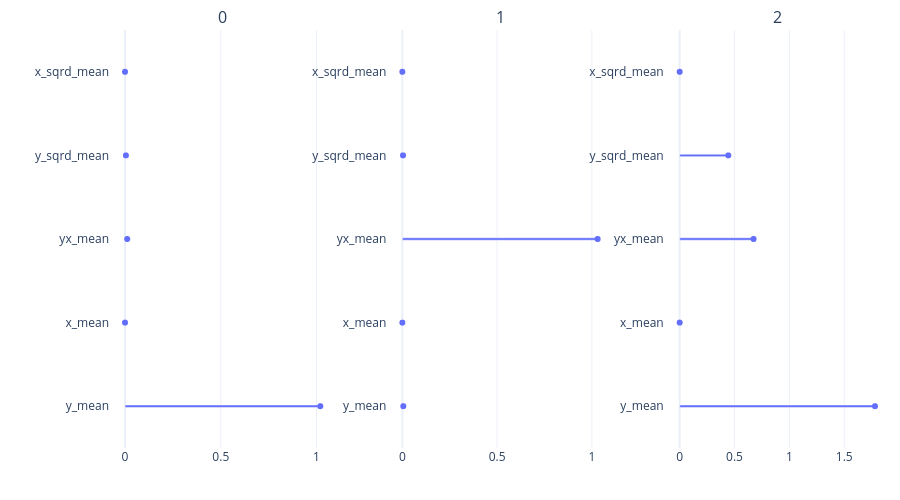

In [14]:
from estimagic.visualization.lollipop_plot import lollipop_plot

sensitivity_data = res["sensitivity"]["sensitivity_to_bias"].abs().T

fig = lollipop_plot(sensitivity_data)

fig = fig.update_layout(height=500, width=900)
fig.show(renderer="png")